# PYTHON ANALYSIS AND VISUALS

In [44]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### connecting the data base

In [37]:
conn = sqlite3.connect('/Users/Marcy_Student/Desktop/marcy/Theme_park_analytics/theme_park_for_python.db')

### 1- Who is coming, how often and how much they spend

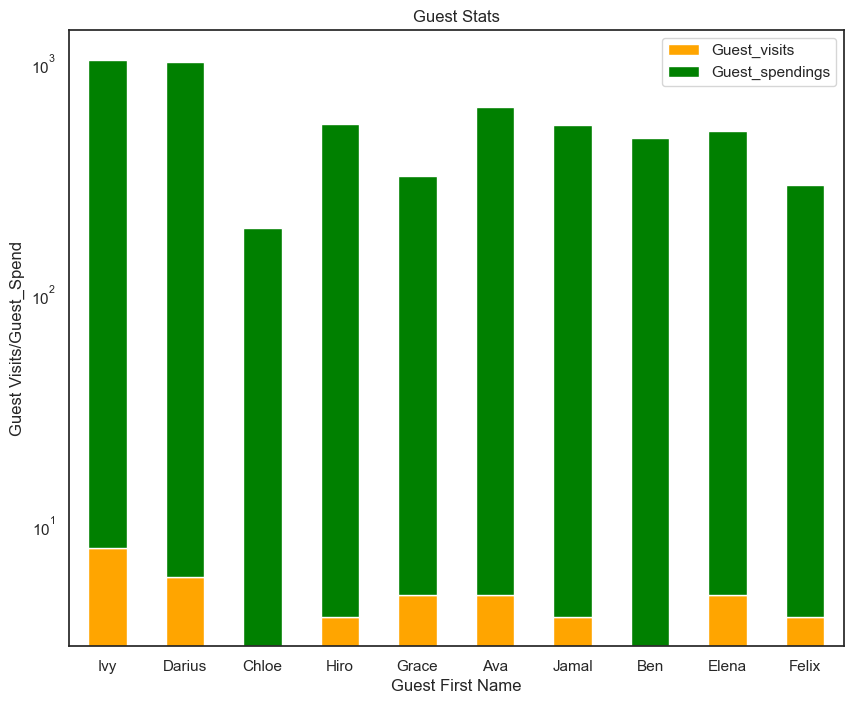

In [38]:
query_1 = 'SELECT * FROM guest_df' ## using my view guest_df
df_guest = pd.read_sql_query(query_1,conn) ##transforming db in dataframe
df_guest.set_index('first_name', inplace=True) #enabling stacked bar by having a fixed index

guest_stats = df_guest[['count_of_visits_F','CLV_revenue_proxy_M']]
sns.set_theme(style='white')
ax = guest_stats.plot(kind='bar', stacked=True, figsize=(10,8), color=['orange','Green'])
plt.yscale("log") ## adjusting the scale
ax.set_xticklabels(guest_stats.index, rotation=0)  # rotate 0 degrees
plt.xlabel('Guest First Name')
plt.ylabel('Guest Visits/Guest_Spend')
ax.legend(['Guest_visits','Guest_spendings'])
plt.tight_layout
plt.title('Guest Stats')
plt.show()


### 2- When And Where Customers are the less or most satisfied 
####   2-1 waiting time

In [39]:
query_2 = 'SELECT ride_event_id,a.attraction_name, re.satisfaction_rating, wait_bins, ride_frame \
FROM dim_attraction a \
LEFT JOIN fact_ride_events re ON a.attraction_id = re.attraction_id'
guest_satisfaction = pd.read_sql_query(query_2,conn)
guest_satisfaction['wait_bins']= guest_satisfaction['wait_bins'].fillna('No_wait')
when_waiting = guest_satisfaction[guest_satisfaction['wait_bins'] != 'No_wait']
when_not_waiting = guest_satisfaction[guest_satisfaction['wait_bins'] == 'No_wait']
when_not_waiting_grouped =when_not_waiting.groupby('attraction_name')[['satisfaction_rating','wait_bins']].agg(pd.Series.mode)

when_waiting_grouped =when_waiting.groupby('attraction_name')[['satisfaction_rating','wait_bins']].agg(pd.Series.mode)

when_waiting_grouped 
#when_not_waiting_grouped 

# despite having mostly a short waiting time, space theather have the lowest satisfaction rating.
# 5/6 of the attractions have mostly a medium waiting time
# The most frequent satisfaction rating accross all attractions when there is no waiting time is below 3.
# the hypothesis here is that even though waiting time can lead to a lower guest satisfaction, there are other reasons to consider. 

,satisfaction_rating,wait_bins
attraction_name,,
dragon drop,5,Medium Wait
galaxy coaster,"[1, 3, 5]",Medium Wait
pirate splash,4,Medium Wait
space theater,1,Short Wait
tiny trucks,4,Medium Wait
wild rapids,2,Medium Wait


#### 2-2 Ride frame (ride_time)

Text(0.5, 1.0, 'Distribution of the satisfaction_rate per ride_frame')

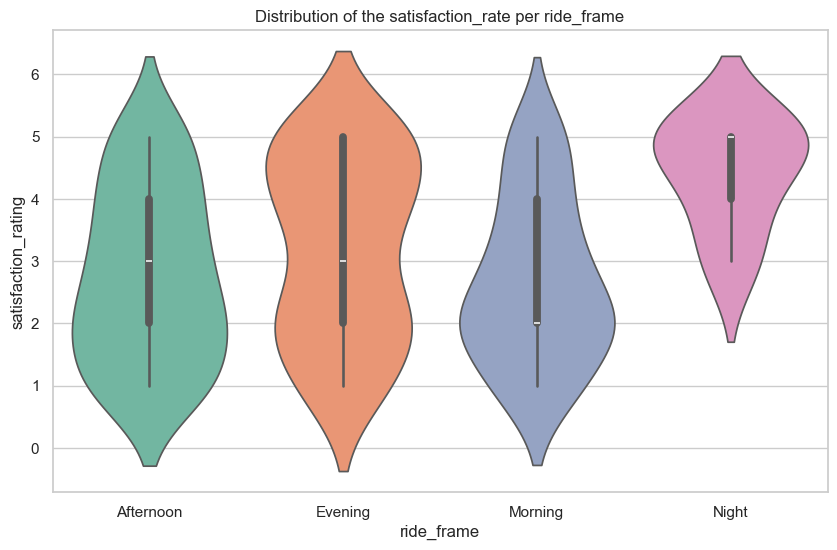

In [40]:
guest_satisfaction
sns.set_theme(style='whitegrid')
ax= plt.figure(figsize=(10,6))
sns.violinplot(guest_satisfaction, x= 'ride_frame', y='satisfaction_rating',palette='Set2',hue='ride_frame')
plt.title('Distribution of the satisfaction_rate per ride_frame')


night rides have the most positive satisfaction rate, Morning and afternoon tend to have more lower satisfaction.

### 3- Daily performance


In [42]:
query_3 = 'SELECT * FROM daily_performance'
daily_performance = pd.read_sql_query(query_3, conn)
daily_performance

,dates,is_weekend,daily_visits,daily_spend,spend_per_visit,running_total
0,2025-07-01,0,2,NaN,NaN,NaN
1,2025-07-02,0,8,811.39,101.42,811.39
2,2025-07-03,0,4,422.10,105.53,1233.49
3,2025-07-04,0,7,647.98,92.57,1881.47
4,2025-07-05,1,7,1051.06,150.15,2932.53
5,2025-07-06,1,6,1128.43,188.07,4060.96
6,2025-07-07,0,10,1138.66,113.87,5199.62
7,2025-07-08,0,3,334.89,111.63,5534.51


In [164]:
fig= make_subplots(rows=1, cols=2, subplot_titles= ("Daily Visits","Daily Spend"))
# Making charts
spending_graph = px.bar(daily_performance, x='dates', y='daily_spend',color_discrete_sequence=px.colors.qualitative.Dark24)
visits_graph = px.bar(daily_performance, x='dates', y='daily_visits',color_discrete_sequence=px.colors.qualitative.Dark24)

# Adding the charts into the subplots
for trace in visits_graph.data:
    fig.add_trace(trace, row=1, col=1)
for trace in spending_graph.data:
    fig.add_trace(trace,row=1, col=2)
    # Update axes to get them labeled, and use dtick to have all the dates displayed instead of some, target each sublot, using row and col
fig.update_xaxes(title_text="Date", row=1, col=1, tickmode="linear", dtick="D1", tickformat="%b %d")
fig.update_yaxes(title_text="Number of Visits", row=1, col=1)
fig.update_xaxes(title_text="Date", row=1, col=2, tickmode="linear", dtick="D1", tickformat="%b %d")
fig.update_yaxes(title_text="Amount Spend ($)", row=1, col=2)
    # Update layout to style my figure, not the subplots
fig.update_layout(title='DAILY SPENDING VS DAILY VISITS',
                height=500, width=900,               # my figure size                   
                plot_bgcolor="white",                # background inside sublot
                paper_bgcolor="lightgray",           # full figure background
                title_x=0.5,                         # my title at the center
                font=dict(size=14, family="Arial,Bold",color="black")

)

### **4-Guest Behaviour:** What patterns drive guests' spendings, how spending correlates with party size and ticket type, Do most frequents visitors spend more ?

In [123]:
query_4 = 'SELECT * FROM behaviour_change'
guest_behaviour = pd.read_sql_query(query_4,conn)
guest_behaviour.head()

,visit_id,guest_id,first_name,party_size,ticket_type_id,ticket_type_name,date_iso,total_spend_dollars,hours_stayed,lag_spend,delta
0,3,1,Ava,4,1,Day Pass,2025-07-02,207.34,Medium Stay,0.00,207.34
1,15,1,Ava,1,1,Day Pass,2025-07-04,119.57,Medium Stay,207.34,-87.77
2,22,1,Ava,1,2,VIP,2025-07-05,0.00,Long Stay,119.57,-119.57
3,35,1,Ava,4,2,VIP,2025-07-07,89.95,Medium Stay,0.00,89.95
4,45,1,Ava,1,2,VIP,2025-07-08,223.26,Medium Stay,89.95,133.31


Text(0.5, 1.0, "Distribution of guests' spendings per party size")

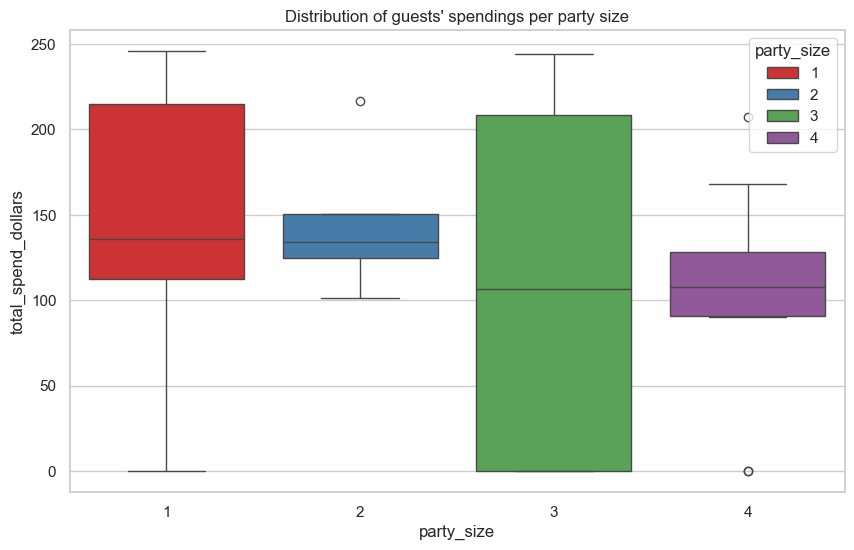

In [124]:
sns.set_theme(style='whitegrid')
ax= plt.figure(figsize=(10,6))
sns.boxplot(guest_behaviour,x='party_size',y='total_spend_dollars',palette='Set1',hue='party_size')
plt.title("Distribution of guests' spendings per party size")

Text(0.5, 1.0, "guests' spending based on duration of visits")

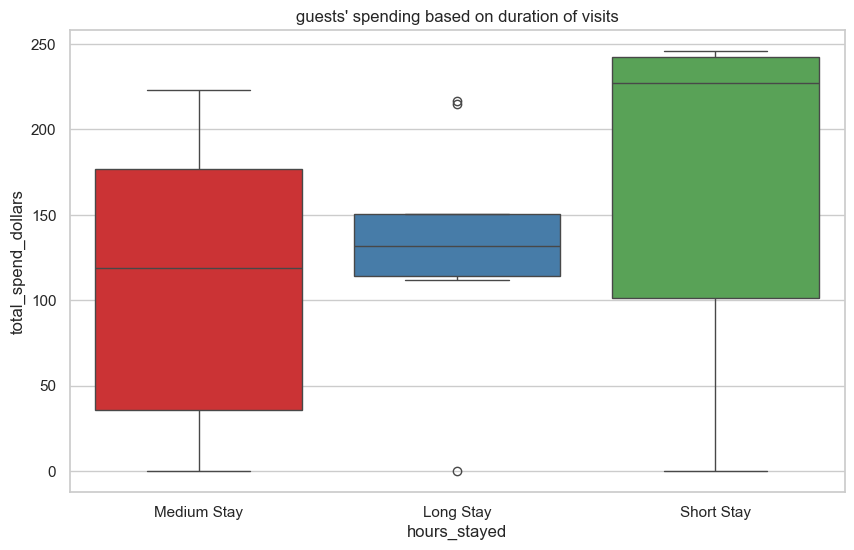

In [128]:
sns.set_theme(style='whitegrid')
ax= plt.figure(figsize=(10,6))
sns.boxplot(guest_behaviour,x='hours_stayed',y='total_spend_dollars',palette='Set1',hue='hours_stayed')
plt.title("guests' spending based on duration of visits")

guests with shorter visits duration tend to spend higher during their visits.

In [140]:
query_5= 'SELECT * FROM guest_df'
guest_df = pd.read_sql_query(query_5,conn)
guest_df.head()

,guest_id,first_name,home_state,visit_id,count_of_visits_F,days_since_last_visit_R,CLV_revenue_proxy_M,Average_spending,ranking,home_state_revenue
0,9,Ivy,CA,47,8,45,1030.01,147.144857,1,2225.81
1,4,Darius,CA,38,6,46,1005.38,167.564097,2,2225.81
2,3,Chloe,CA,37,3,46,190.42,95.210000,3,2225.81
3,8,Hiro,FL,42,4,46,542.93,135.731562,1,861.69
4,7,Grace,FL,41,5,46,318.76,63.752000,2,861.69


Text(0, 0.5, 'Average spending per visit')

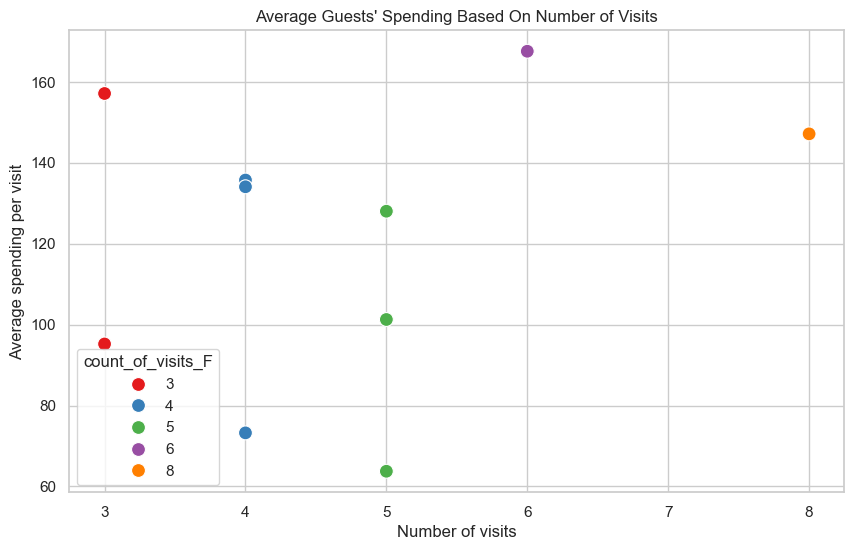

In [145]:
sns.set_theme(style='whitegrid')
ax= plt.figure(figsize=(10,6))
sns.scatterplot(guest_df,x='count_of_visits_F',y='Average_spending',palette='Set1',hue='count_of_visits_F',s=100)
plt.title("Average Guests' Spending Based On Number of Visits")
plt.xlabel('Number of visits')
plt.ylabel('Average spending per visit')

1. full engaged guests who visited less but spend high :like Ben 
2. engaged and frequent guests who spread out their spendings:like Ivy 
3. Consistent average guests who visited half of the days, and spend normal 
4. relatively frequent and low engaged guests who visited 5 days and spend little in average.


### 5- Mapping Guest Value Across States.

In [168]:
fig = px.treemap(guest_df,
                 path=['first_name','home_state'],
                 values='CLV_revenue_proxy_M',
                 color='CLV_revenue_proxy_M',     
                color_continuous_scale='Blues')
fig.update_layout(title='Guests value and their location',
                height=500, width=800,               # my figure size                   
                plot_bgcolor="white",                # my background
                title_x=0.5,                         # my title at the center
                font=dict(size=14, family="Arial,Bold",color="black"))
fig.show()